In [1]:
from __future__ import print_function

In [2]:
import urllib
import bz2
import os
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
BASE_URL = "http://grail.cs.washington.edu/projects/bal/data/ladybug/"
FILE_NAME = "problem-49-7776-pre.txt.bz2"
URL = BASE_URL + FILE_NAME

In [4]:
if not os.path.isfile(FILE_NAME):
    urllib.request.urlretrieve(URL, FILE_NAME)

In [5]:
def read_bal_data(file_name):
    with bz2.open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(int, file.readline().split())
    
        camera_indices = np.empty(n_observations, dtype = int)
        point_indices = np.empty(n_observations, dtype = int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = camera_index
            point_indices[i] = point_index
            points_2d[i] = [float(x), float(y)]

            camera_params = np.empty(n_cameras*9)

        for i in range(n_cameras*9):
            camera_params[i] = float(file.readline())

        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points*3)

        for i in range(n_points*3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))
            
    return camera_params, points_3d, camera_indices, point_indices, points_2d

In [22]:
camera_params, points_3d, camera_indices, point_indices, points_2d = read_bal_data(FILE_NAME)

In [23]:
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]

n = 9*n_cameras + 3*n_points
m = 2*points_2d.shape[0]

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 49
n_points: 7776
Total number of parameters: 23769
Total number of residuals: 63686


In [24]:
def rotate(points, rot_vecs):
    
    theta = np.linalg.norm(rot_vecs, axis = 1)[:, np.newaxis]
    with np.errstate(invalid = 'ignore'):
        v = rot_vecs/theta
        v = np.nan_to_num(v)
#     print(v.shape, points.shape)
    
    dot = np.sum(points*v, axis = 1)[:, np.newaxis]
    
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    
    return cos_theta*points + sin_theta*np.cross(v, points) + dot*(1-cos_theta)*v

In [25]:
def project(points, camera_params):
    points_proj = rotate(points, camera_params[:, :3])
    points_proj += camera_params[:, 3:6]
    points_proj = -points_proj[:, :2]/points_proj[: , 2, np.newaxis]
    f = camera_params[:, 6]
    k1 = camera_params[:, 7]
    k2 = camera_params[:, 8]
    
    n = np.sum(points_proj**2, axis = 1)
    r = 1 + n*k1 + k2*n**2
    points_proj *= (r*f)[:, np.newaxis]
    return points_proj

In [26]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d, points_3d):
    camera_params = params[:n_cameras*9].reshape((n_cameras, 9))
#     points_3d = params[n_cameras*9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    
    return (points_proj - points_2d).ravel()

In [27]:
from scipy.sparse import lil_matrix

In [28]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2
#     n = n_cameras*9
    n = n_cameras*9 + n_points*3
    A = lil_matrix((m,n), dtype = int)
    i = np.arange(camera_indices.size)
    
    for s in range(9):
        A[2*i, camera_indices*9 + s] = 1
        A[2*i + 1, camera_indices*9 + s] = 1
    
    for s in range(3):
        A[2*i, n_cameras*9 + point_indices*3 + s] = 1
        A[2*i + 1, n_cameras*9 + point_indices*3 + s] = 1
    
    return A


In [29]:
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
# x0 = np.hstack((camera_params.ravel()))

In [30]:
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d, points_3d)

In [42]:
np.power(f0,2).sum()/2

850912.4606808405

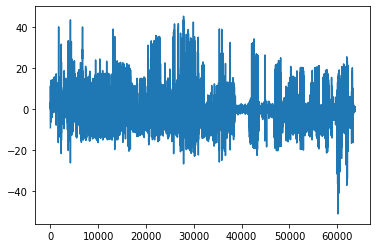

In [31]:
plt.plot(f0)

In [32]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)

In [33]:
import time
from scipy.optimize import least_squares

In [34]:
t0 = time.time()
res = least_squares(fun, x0, jac_sparsity=A, verbose = 2, x_scale = 'jac', ftol = 1e-4,
                   method = 'trf', args = (n_cameras, n_points, camera_indices, point_indices,
                                           points_2d, points_3d))
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5091e+05                                    8.57e+06    
       1              2         2.8554e+04      8.22e+05       1.33e+01       4.07e+04    
       2              3         2.8515e+04      3.93e+01       5.88e-01       4.54e+02    
       3              4         2.8515e+04      1.86e-02       2.74e-02       2.20e+02    
`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 8.5091e+05, final cost 2.8515e+04, first-order optimality 2.20e+02.


In [39]:
res.grad

array([-0.47011423, -2.57487975, -0.32846814, ...,  0.        ,
        0.        ,  0.        ])

In [38]:
n

23769